In [6]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from os import walk
from collections import Counter
from sklearn.cluster import KMeans
from random import sample
from copy import deepcopy
from string import punctuation
from collections import Counter

In [1]:
def cluster(n_clusters, target_list, corpus, stem_switch, context_switch, span = 3):
    if stem_switch == 1:
        stemmer = PorterStemmer()
    # whole doc as context
    vocabulary = []
    if context_switch == 1:
        # build vocabulary
        for i in range(len(corpus)):
            for j in range(len(corpus[i])):
                if stem_switch == 1 and corpus[i][j] not in target_list:
                    corpus[i][j] = stemmer.stem(corpus[i][j])
                if corpus[i][j] not in vocabulary:
                    vocabulary.append(corpus[i][j])
    
    elif context_switch == 3:
        contexts_list = []
        # gather context
        for corpora in corpus:
            for target in target_list:
                if target in corpora:
                    # extract window of all occcurences
                    location_list = [index for index, word in enumerate(corpora) if word == target]
                    for location in location_list:
                        lowbound = max(0, location - span)
                        uppbound = min(location + (span+1), len(corpora))
                        # index of target list in current window
                        if location >= span:
                            index = span
                        else:
                            index = location
                        contexts_list.append([index, deepcopy(corpora[lowbound:uppbound])])

        # build vocabulary
        for i in range(len(contexts_list)):
            for j in range(len(contexts_list[i][1])):
                # target word itself shall not be considered
                if j != contexts_list[i][0]:
                    if stem_switch == 1:
                        contexts_list[i][1][j] = stemmer.stem(contexts_list[i][1][j])
                    if contexts_list[i][1][j] not in vocabulary:
                        vocabulary.append(contexts_list[i][1][j])

        corpus = contexts_list
    
    # print(len(vocabulary))
    # build term-context matrix
    targ_word_mat = [[0 for i in range(len(vocabulary))] for j in range(len(target_list))]
    if context_switch == 1:
        for corpora in corpus:
            # get list of target words appear in current corpora and how many times this word appears 
            # to determine how many times current corpora should act as window for current target word

            # frequency that each word appears in current corpora
            histogram = Counter(corpora)
            appearance = []
            for i in range(len(target_list)):
                if target_list[i] in histogram.keys():
                    appearance.append((i, histogram[target_list[i]]))
            for word in corpora:
                for (index, frequency) in appearance:
                    targ_word_mat[index][vocabulary.index(word)] += frequency
            # target word itself shall not be counted
            for (index, frequency) in appearance:
                targ_word_mat[index][vocabulary.index(target_list[index])] -= frequency
    
    elif context_switch == 3:
        for corpora in corpus:
            # target is at center of window
            skip = corpora[0]
            # get index of target in target_list
            row_index = target_list.index(corpora[1][skip])
            for i in range(len(corpora[1])):
                if i != skip: # target word itself shall not be counted
                    targ_word_mat[row_index][vocabulary.index(corpora[1][i])] += 1

    result = KMeans(n_clusters=n_clusters).fit(targ_word_mat)
    # print(result.labels_)
    clusters = []
    for i in range(n_clusters):
        clusters.append([])
    # assign words to clusters according to its label
    for i in range(len(target_list)):
        clusters[result.labels_[i]].append(target_list[i])
    # print('clusters:')
    # print(clusters)
    true = 0
    for cluster in clusters:
        if len(cluster) == 2 and cluster[0] == cluster[1][::-1]:
            true += 1
    # print('accuracy: ' + str(true/n_clusters))
    return true/n_clusters

In [4]:
# use window as context
def context_3(target_list, stem_switch, set_switch):
    corpus = []
    # read corpusB
    # assume all .ntext files locate directly under directory /corpusB
    if set_switch == 0 or set_switch == 2:
        for _, _, filenames in walk('corpusB'):
            for filename in filenames:
                f = open('corpusB/'+filename, "r", encoding='latin-1')
                # to lower case
                s = f.read().replace('\n', ' ').lower()
                s = s.translate(str.maketrans('', '', punctuation))
                tokens = word_tokenize(s)
                corpus.append(tokens)
    if set_switch == 1 or set_switch == 2:
        for _, _, filenames in walk('corpusC'):
            for filename in filenames:
                f = open('corpusC/'+filename, "r", encoding='latin-1')
                # to lower case
                s = f.read().replace('\n', ' ').lower()
                s = s.translate(str.maketrans('', '', punctuation))
                tokens = word_tokenize(s)
                corpus.append(tokens)

    rev_list = []
    # add all reverted words to target list
    for target in target_list:
        rev_list.append(target[::-1])
    rev_list.extend(target_list)

    occurences = []
    for i in range(len(target_list)):
        occurences.append([])
    # find all occurences of target word in corpus
    for k in range(len(target_list)):
        for i in range(len(corpus)):
            for j in range(len(corpus[i])):
                if corpus[i][j] == target_list[k]:
                    occurences[k].append((i, j))
        
    # repeat 5 times
    curve = []
    for span in range(2,21):
        acc_coll = []
        print('stemmer_switch = '+str(stem_switch)+', set_switch = '+str(set_switch)+', span = '+str(span))
        for _ in range(5):
            korpus = deepcopy(corpus)
            for k in range(len(occurences)):
                # randomly selete half of occurences,
                # but target 'got' has only 1 occurence in original corpus! how to cope?
                picklist = sample(occurences[k], len(occurences[k])//2)
                # print('word = '+target_list[k] + ', # of occurences = ' + str(len(occurences[k])))
                # replace selected occurences with reverted words
                for (i, j) in picklist:
                    korpus[i][j] = korpus[i][j][::-1]
            acc_coll.append(cluster(50, rev_list, korpus, stem_switch, context_switch=3, span=span))
        avg_acc = sum(acc_coll)/5
        print('accuracy: '+str(acc_coll)+', avg = '+ str(avg_acc))
        curve.append(avg_acc)
    return curve

In [4]:
# use doc as context
def context_1(target_list, stem_switch, set_switch):
    corpus = []
    # read corpusB
    # assume all .ntext files locate directly under directory /corpusB
    if set_switch == 0 or set_switch == 2:
        for _, _, filenames in walk('corpusB'):
            for filename in filenames:
                f = open('corpusB/'+filename, "r", encoding='latin-1')
                # to lower case
                s = f.read().replace('\n', ' ').lower()
                s = s.translate(str.maketrans('', '', punctuation))
                tokens = word_tokenize(s)
                corpus.append(tokens)
    if set_switch == 1 or set_switch == 2:
        for _, _, filenames in walk('corpusC'):
            for filename in filenames:
                f = open('corpusC/'+filename, "r", encoding='latin-1')
                # to lower case
                s = f.read().replace('\n', ' ').lower()
                s = s.translate(str.maketrans('', '', punctuation))
                tokens = word_tokenize(s)
                corpus.append(tokens)

    rev_list = []
    # add all reverted words to target list
    for target in target_list:
        rev_list.append(target[::-1])
    rev_list.extend(target_list)

    occurences = []
    for i in range(len(target_list)):
        occurences.append([])
    # find all occurences of target word in corpus
    for k in range(len(target_list)):
        for i in range(len(corpus)):
            for j in range(len(corpus[i])):
                if corpus[i][j] == target_list[k]:
                    occurences[k].append((i, j))
        
    # repeat 5 times
    acc_coll = []
    for _ in range(5):
        korpus = deepcopy(corpus)
        for k in range(len(occurences)):
            # randomly selete half of occurences,
            # but target 'got' has only 1 occurence in original corpus! how to cope?
            picklist = sample(occurences[k], len(occurences[k])//2)
            # print('word = '+target_list[k] + ', # of occurences = ' + str(len(occurences[k])))
            # replace selected occurences with reverted words
            for (i, j) in picklist:
                korpus[i][j] = korpus[i][j][::-1]
        acc_coll.append(cluster(50, rev_list, korpus, stem_switch, context_switch=1))
    avg_acc = sum(acc_coll)/5
    print('avg = '+ str(avg_acc))
    return avg_acc

In [8]:
# read target word list
with open('listD','r') as fp:
    target_list = fp.read()
target_list = word_tokenize(target_list)

In [61]:
%%time
# use window as context
curve_collect = []
for stem_switch in range(2):
    for set_switch in range(3):
        curve_collect.append(context_3(target_list, stem_switch, set_switch))

stemmer_switch = 0, set_switch = 0, span = 2
accuracy: [0.56, 0.44, 0.5, 0.38, 0.44], avg = 0.46399999999999997
stemmer_switch = 0, set_switch = 0, span = 3
accuracy: [0.46, 0.46, 0.42, 0.52, 0.48], avg = 0.46799999999999997
stemmer_switch = 0, set_switch = 0, span = 4
accuracy: [0.42, 0.44, 0.42, 0.42, 0.42], avg = 0.42400000000000004
stemmer_switch = 0, set_switch = 0, span = 5
accuracy: [0.36, 0.44, 0.46, 0.46, 0.42], avg = 0.42800000000000005
stemmer_switch = 0, set_switch = 0, span = 6
accuracy: [0.48, 0.44, 0.38, 0.42, 0.36], avg = 0.4159999999999999
stemmer_switch = 0, set_switch = 0, span = 7
accuracy: [0.4, 0.46, 0.42, 0.4, 0.46], avg = 0.42800000000000005
stemmer_switch = 0, set_switch = 0, span = 8
accuracy: [0.4, 0.48, 0.42, 0.48, 0.4], avg = 0.43600000000000005
stemmer_switch = 0, set_switch = 0, span = 9
accuracy: [0.42, 0.42, 0.42, 0.38, 0.4], avg = 0.40800000000000003
stemmer_switch = 0, set_switch = 0, span = 10
accuracy: [0.38, 0.42, 0.34, 0.34, 0.4], avg = 0.37600000

accuracy: [0.84, 0.84, 0.94, 0.82, 0.86], avg = 0.86
stemmer_switch = 1, set_switch = 1, span = 4
accuracy: [0.88, 0.88, 0.88, 0.88, 0.88], avg = 0.8800000000000001
stemmer_switch = 1, set_switch = 1, span = 5
accuracy: [0.9, 0.84, 0.88, 0.76, 0.8], avg = 0.836
stemmer_switch = 1, set_switch = 1, span = 6
accuracy: [0.92, 0.76, 0.82, 0.74, 0.8], avg = 0.808
stemmer_switch = 1, set_switch = 1, span = 7
accuracy: [0.68, 0.74, 0.76, 0.86, 0.88], avg = 0.7839999999999999
stemmer_switch = 1, set_switch = 1, span = 8
accuracy: [0.88, 0.82, 0.78, 0.88, 0.82], avg = 0.836
stemmer_switch = 1, set_switch = 1, span = 9
accuracy: [0.78, 0.84, 0.78, 0.9, 0.84], avg = 0.8280000000000001
stemmer_switch = 1, set_switch = 1, span = 10
accuracy: [0.82, 0.8, 0.78, 0.82, 0.9], avg = 0.8240000000000001
stemmer_switch = 1, set_switch = 1, span = 11
accuracy: [0.8, 0.84, 0.8, 0.82, 0.8], avg = 0.812
stemmer_switch = 1, set_switch = 1, span = 12
accuracy: [0.82, 0.84, 0.84, 0.94, 0.76], avg = 0.84000000000000

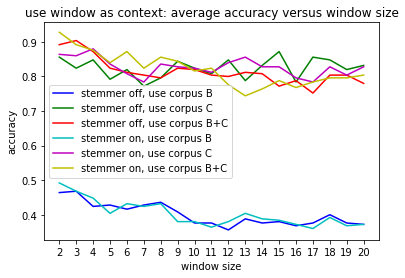

In [62]:
# use window as context
from numpy import array
import matplotlib.pyplot as plt
x_axix = array(range(2,21))
plt.title('use window as context: average accuracy versus window size')
plt.plot(x_axix, array(curve_collect[0]), color='b', label='stemmer off, use corpus B')
plt.plot(x_axix, array(curve_collect[1]), color='g', label='stemmer off, use corpus C')
plt.plot(x_axix, array(curve_collect[2]), color='r', label='stemmer off, use corpus B+C')
plt.plot(x_axix, array(curve_collect[3]), color='c', label='stemmer on, use corpus B')
plt.plot(x_axix, array(curve_collect[4]), color='m', label='stemmer on, use corpus C')
plt.plot(x_axix, array(curve_collect[5]), color='y', label='stemmer on, use corpus B+C')
plt.legend() # 显示图例
 
plt.xlabel('window size')
plt.ylabel('accuracy')
plt.show()

In [6]:
%%time
# use doc as context
print('use whole doc as context:')
print('stemmer off, use corpus B,   average over 5 times is:'+str(context_1(target_list, stem_switch=0, set_switch=0)))# this line is part b
print('stemmer off, use corpus C,   average over 5 times is:'+str(context_1(target_list, stem_switch=0, set_switch=1)))
print('stemmer off, use corpus B+C, average over 5 times is:'+str(context_1(target_list, stem_switch=0, set_switch=2)))
print('stemmer on,  use corpus B,   average over 5 times is:'+str(context_1(target_list, stem_switch=1, set_switch=0)))
print('stemmer on,  use corpus C,   average over 5 times is:'+str(context_1(target_list, stem_switch=1, set_switch=1)))
print('stemmer on,  use corpus B+C, average over 5 times is:'+str(context_1(target_list, stem_switch=1, set_switch=2)))

use whole doc as context:
avg = 0.32399999999999995
stemmer off, use corpus B,   average over 5 times is:0.32399999999999995
avg = 0.6439999999999999
stemmer off, use corpus C,   average over 5 times is:0.6439999999999999
avg = 0.6000000000000001
stemmer off, use corpus B+C, average over 5 times is:0.6000000000000001
avg = 0.128
stemmer on,  use corpus B,   average over 5 times is:0.128
avg = 0.21199999999999997
stemmer on,  use corpus C,   average over 5 times is:0.21199999999999997
avg = 0.14400000000000002
stemmer on,  use corpus B+C, average over 5 times is:0.14400000000000002
CPU times: user 59min 29s, sys: 1min 49s, total: 1h 1min 19s
Wall time: 58min 40s
